In [55]:
%load_ext autoreload
%autoreload 2

from epsilon_transformers.persistence import S3Persister, HackyPersister
from epsilon_transformers.training.configs.model_configs import RawModelConfig
from epsilon_transformers.process.processes import RRXOR, Mess3
from epsilon_transformers.analysis.activation_analysis import get_beliefs_for_transformer_inputs
from epsilon_transformers.visualization.plots import _project_to_simplex
import seaborn as sns

import numpy as np
import torch
import plotly.express as px
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Get the model checkpoints (.pt files) and the config from s3

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#persister = S3Persister(collection_location="mess3-0.15-0.6-longrun")
#persister = S3Persister(collection_location="mess3-0.05-0.85-longrun")
persister = HackyPersister(dir_path=pathlib.Path("./models/mess3"))
def get_model_checkpoints(persister: S3Persister):
    filenames = persister.list_objects()
    filenames_pt = [x for x in filenames if ".pt" in x]
    filenames_pt.sort(key=lambda x: int(x.split("_")[-1].split(".")[0]))
    return filenames_pt

def load_final_model(persister: S3Persister, file_num = -1):
    checkpoint_filenames = get_model_checkpoints(persister)
    print(f"Checkpoints found: {len(checkpoint_filenames)}")
    model = persister.load_model(object_name=checkpoint_filenames[file_num], device='cpu')
    print(f"Last checkpoint: {checkpoint_filenames[file_num]}")
    return model

model = load_final_model(persister)


Checkpoints found: 99939
Last checkpoint: 639622400.pt


In [3]:
train_config = persister.load_json(object_name='train_config.json')

print("\n".join(f"{k}: {v}" for k, v in train_config.items()))

seed: 42
n_ctx: 10
act_fn: relu
d_head: 8
d_model: 64
d_vocab: 3
n_heads: 1
n_iters: 10
n_layers: 4
attn_only: False
optimizer: sgd
batch_size: 64
num_epochs: 1000000
init_weights: True
weight_decay: 0
attention_dir: causal
learning_rate: 0.01
use_attn_scale: True
normalization_type: LN


In [4]:
val_log = persister.load_csv(object_name='val_log.csv')
val_log


,_timestamp,relative_loss_9,val_relative_loss_3,val_relative_loss,relative_loss_6,_runtime,relative_loss_4,val_relative_loss_2,relative_loss_7,val_loss,...,val_relative_loss_8,relative_loss_5,_step,relative_loss_2,relative_loss_3,val_relative_loss_9,val_relative_loss_1,relative_loss_8,relative_loss_0,trained_tokens
0,1.714286e+09,NaN,1.113202,1.100153,NaN,6.593347,NaN,1.051020,NaN,0.882340,...,1.157566,NaN,10.0,NaN,NaN,1.140331,1.053790,NaN,NaN,6400
1,1.714286e+09,NaN,1.073788,1.064314,NaN,8.775142,NaN,1.021850,NaN,0.853662,...,1.114765,NaN,21.0,NaN,NaN,1.090940,1.022911,NaN,NaN,12800
2,1.714286e+09,NaN,1.035402,1.049907,NaN,10.846117,NaN,1.023127,NaN,0.842314,...,1.077243,NaN,32.0,NaN,NaN,1.074432,1.043934,NaN,NaN,19200
3,1.714286e+09,NaN,1.040753,1.041970,NaN,12.881809,NaN,1.013580,NaN,0.835935,...,1.072088,NaN,43.0,NaN,NaN,1.063980,1.019984,NaN,NaN,25600
4,1.714286e+09,NaN,1.039009,1.042674,NaN,14.982496,NaN,1.016718,NaN,0.836512,...,1.071322,NaN,54.0,NaN,NaN,1.064513,1.029669,NaN,NaN,32000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99927,1.714487e+09,NaN,1.000465,1.000468,NaN,201393.886413,NaN,1.000468,NaN,0.802885,...,1.000556,NaN,1099207.0,NaN,NaN,1.000497,1.000330,NaN,NaN,639539200
99928,1.714487e+09,NaN,1.000378,1.000410,NaN,201397.000678,NaN,1.000340,NaN,0.802839,...,1.000539,NaN,1099218.0,NaN,NaN,1.000469,1.000299,NaN,NaN,639545600
99929,1.714487e+09,NaN,1.000215,1.000265,NaN,201399.838155,NaN,1.000199,NaN,0.802723,...,1.000384,NaN,1099229.0,NaN,NaN,1.000315,1.000113,NaN,NaN,639552000
99930,1.714487e+09,NaN,1.000207,1.000251,NaN,201402.645488,NaN,1.000155,NaN,0.802712,...,1.000387,NaN,1099240.0,NaN,NaN,1.000319,1.000083,NaN,NaN,639558400


# Initialize the Mess3 process
This library has a Process class that we use to define a data generating HMM.

The most important part of the process is the transition matrix, which defines the transitions between states. You can get it via `process.transition_matrix`. It is a numpy array of shape (num_emission, num_states, num_states), and defines the transition probabilities from state i to state j given emission k.

The process also has a `state_names_dict`, which is a dictionary mapping state names to state indices. You can get it via `process.state_names_dict`.


In [5]:
process = Mess3(0.05, 0.85)
print(process)



mess3 Process
Number of states: 3
Vocabulary length: 3
Transition matrix shape: (3, 3, 3)


In [6]:
process.transition_matrix

array([[[0.765  , 0.00375, 0.00375],
        [0.0425 , 0.0675 , 0.00375],
        [0.0425 , 0.00375, 0.0675 ]],

       [[0.0675 , 0.0425 , 0.00375],
        [0.00375, 0.765  , 0.00375],
        [0.00375, 0.0425 , 0.0675 ]],

       [[0.0675 , 0.00375, 0.0425 ],
        [0.00375, 0.0675 , 0.0425 ],
        [0.00375, 0.00375, 0.765  ]]])

In [8]:
process.state_names_dict

{'A': 0, 'B': 1, 'C': 2}

# Visualizing the process

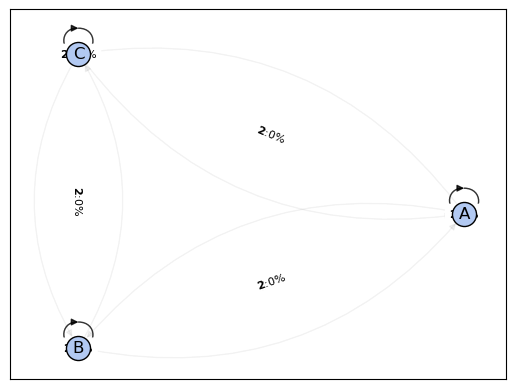

In [9]:
from epsilon_transformers.visualization.graph import transition_matrix_to_graph, visualize_graph
graph = transition_matrix_to_graph(transition_matrix=process.transition_matrix,state_names=process.state_names_dict)
visualize_graph(graph, draw_mixed_state=True, layout='spectral')

In [ ]:
# visualize the ground truth simplex


# Computing the Mixed-State Presentation

The computation of the MSP from the process is in two steps:
1. Compute a tree of that keeps track of belief states as nodes, and emissions as edges. This is called a `MixedStateTree` and you can get it via `process.derive_mixed_state_presentation(depth=N)`, where N is the maximum length of sequences you want to consider.
2. Once we have a tree, we can then compute the MSP via `msp_tree.build_transition_graph()`. This returns a transition matrix which we can then use to create another `Process` using the `TransitionMatrixProcess` class.

We go through these steps and then visualize the MSP.

In [10]:
mixed_state_tree = process.derive_mixed_state_presentation(depth=train_config["n_ctx"] + 1)
MSP_transition_matrix = mixed_state_tree.build_msp_transition_matrix()

# Simplex Analysis

## Ground Truth Simplex

To get the ground truth simplex structure, we need to get all paths of any length on the mixed state tree, and their associated belief states. To do this, we use `mixed_state_tree.paths_and_belief_states`, which returns a list of tuples, where the first element is the path, and the second element is the belief state associated with it.



In [11]:
# in order to plot the belief states in the simplex, we need to get the paths and beliefs from the MSP
tree_paths, tree_beliefs = mixed_state_tree.paths_and_belief_states

# lets print out the first few paths and beliefs
for path, belief in zip(tree_paths[:5], tree_beliefs[:5]):
    print(f"Path: {''.join([str(x) for x in path])}, Belief: {belief}")

Path: 2020122201, Belief: [0.21343287 0.49685942 0.28970771]
Path: 2221101120, Belief: [0.5041189  0.28398334 0.21189776]
Path: 2211020, Belief: [0.75099842 0.07165614 0.17734544]
Path: 22002110002, Belief: [0.56138118 0.03801478 0.40060404]
Path: 10000110220, Belief: [0.56248168 0.03972232 0.397796  ]


In [39]:
# the MSP states are the unique beliefs in the tree
msp_beliefs = [tuple(round(b, 5) for b in belief) for belief in tree_beliefs]
print(f"Number of Unique beliefs: {len(set(msp_beliefs))} out of {len(msp_beliefs)}")

Number of Unique beliefs: 237844 out of 265720


In [40]:
# now lets index each belief
msp_belief_index = {b: i for i, b in enumerate(set(msp_beliefs))}

for i in range(5):
    ith_belief = list(msp_belief_index.keys())[i]
    print(f"{ith_belief} is indexed as {msp_belief_index[ith_belief]}")

(0.43566, 0.05426, 0.51008) is indexed as 0
(0.19554, 0.57324, 0.23122) is indexed as 1
(0.03927, 0.05051, 0.91022) is indexed as 2
(0.06124, 0.92584, 0.01292) is indexed as 3
(0.02297, 0.01413, 0.96291) is indexed as 4


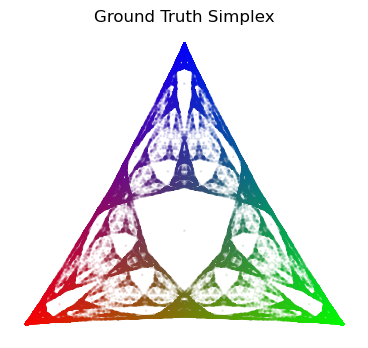

In [42]:
ground_truth_simplex = _project_to_simplex(np.array(list(msp_belief_index.keys())))
plt.figure(figsize=(4.5, 4))
plt.scatter(ground_truth_simplex[0], ground_truth_simplex[1], c=list(msp_belief_index.keys()), alpha=.1, s=1)
plt.title("Ground Truth Simplex")
plt.gca().set_axis_off()
plt.show()


# Find Simplex in Transformer Activations

In [43]:
# now lets set up all the inputs as they arrive into the transformer
device = 'cpu'
transformer_inputs = [x for x in tree_paths if len(x) == train_config["n_ctx"]]
transformer_inputs = torch.tensor(transformer_inputs, dtype=torch.int).to(device)

# print first few batches
print(transformer_inputs[:5])

tensor([[2, 0, 2, 0, 1, 2, 2, 2, 0, 1],
        [2, 2, 2, 1, 1, 0, 1, 1, 2, 0],
        [2, 0, 2, 0, 1, 2, 2, 2, 0, 2],
        [2, 2, 2, 1, 1, 0, 2, 0, 0, 1],
        [2, 2, 2, 1, 1, 0, 1, 1, 1, 1]], dtype=torch.int32)


In [44]:
transformer_input_beliefs, transformer_input_belief_indices = get_beliefs_for_transformer_inputs(transformer_inputs, msp_belief_index, tree_paths, tree_beliefs)
print(f"Transformer Input Beliefs: {transformer_input_beliefs.shape}, Transformer Input Belief Indices: {transformer_input_belief_indices.shape}")

Transformer Input Beliefs: torch.Size([59049, 10, 3]), Transformer Input Belief Indices: torch.Size([59049, 10])


In [45]:
_, activations = model.run_with_cache(transformer_inputs, names_filter=lambda x: 'resid_post' in x)
#_, activations = model.run_with_cache(transformer_inputs)
#activations['blocks.0.hook_resid_mid'].shape  'ln_final.hook_normalized'
#activations = activations['blocks.3.hook_resid_post']
activations.keys()

In [46]:
# we now have activations [batch, n_ctx, d_model]
# and we have transformer_input_beliefs [batch, n_ctx, belief_dim]
# and we have transformer_input_belief_indices [batch, n_ctx]

# in the end we want to do linear regression between the activations and the transformer_input_beliefs
def run_activation_to_beliefs_regression(activations, ground_truth_beliefs):

    # make sure the first two dimensions are the same
    assert activations.shape[0] == ground_truth_beliefs.shape[0]
    assert activations.shape[1] == ground_truth_beliefs.shape[1]

    # flatten the activations
    batch_size, n_ctx, d_model = activations.shape
    belief_dim = ground_truth_beliefs.shape[-1]
    activations_flattened = activations.view(-1, d_model) # [batch * n_ctx, d_model]
    ground_truth_beliefs_flattened = ground_truth_beliefs.view(-1, belief_dim) # [batch * n_ctx, belief_dim]
    
    # run the regression
    regression = LinearRegression()
    regression.fit(activations_flattened, ground_truth_beliefs_flattened)

    # get the belief predictions
    belief_predictions = regression.predict(activations_flattened) # [batch * n_ctx, belief_dim]
    belief_predictions = belief_predictions.reshape(batch_size, n_ctx, belief_dim)

    return regression, belief_predictions



In [47]:
#acts = torch.concatenate((activations["blocks.0.ln1.hook_normalized"], activations["blocks.1.ln1.hook_normalized"], activations["blocks.2.ln1.hook_normalized"], activations["blocks.3.ln1.hook_normalized"]), dim=-1)
#acts = activations['ln_final.hook_normalized']
acts = activations['blocks.3.hook_resid_post']
regression, belief_predictions = run_activation_to_beliefs_regression(acts, transformer_input_beliefs)
print(belief_predictions.shape)



(59049, 10, 3)


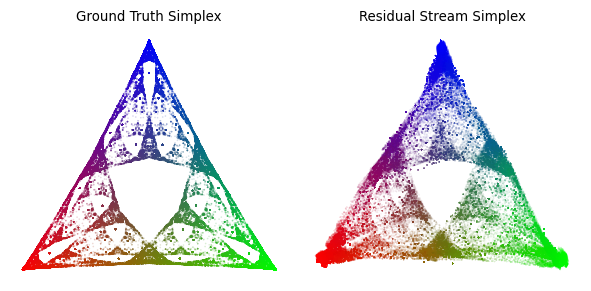

In [54]:
from epsilon_transformers.analysis.activation_analysis import find_msp_subspace_in_residual_stream
from epsilon_transformers.process.processes import Mess3
from epsilon_transformers.visualization.plots import plot_ground_truth_and_evaluated_2d_simplex


belief_predictions_flattened = belief_predictions.reshape(-1, 3)
transformer_input_belief_flattened = transformer_input_beliefs.reshape(-1, 3)

# project to simplex
belief_true_projected = _project_to_simplex(transformer_input_belief_flattened)
belief_pred_projected = _project_to_simplex(belief_predictions_flattened)

rgb_colors =  transformer_input_belief_flattened.cpu().numpy()
#rgb_colors = rgb_colors.astype(int)

sns.set_context("paper")
fig, axes = plt.subplots(1, 2, figsize=(6, 3))

# Plotting the true beliefs projected onto the simplex
axes[0].scatter(belief_true_projected[0], belief_true_projected[1], marker='.', c=rgb_colors, alpha=0.2, s=0.5)
axes[0].axis('off')
axes[0].set_title("Ground Truth Simplex")

# Plotting the predicted beliefs projected onto the simplex
axes[1].scatter(belief_pred_projected[0], belief_pred_projected[1], marker='.', c=rgb_colors, alpha=0.5, s=0.01)
axes[1].axis('off')
axes[1].set_title("Residual Stream Simplex")

# Adjust layout for better spacing
plt.tight_layout()

# Display the figure
plt.show()

